<h4>Transfer Learning</h4>

<h5>Imports</h5>

In [2]:
from urllib.parse import urlparse, parse_qs, urlencode, urlunparse, unquote_plus
import tensorflow as tf
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Input, Dropout
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
import jsonlines
import os
import json
import pickle
from sklearn.metrics import f1_score, accuracy_score, precision_score
from typing import Callable
from sklearn import svm
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp
from tensorflow.python.profiler import profiler_v2 as profiler
import visualkeras
from PIL import ImageFont
import time
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, precision_recall_curve
import matplotlib.pyplot as plt
import math

2023-06-10 13:14:14.997140: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-10 13:14:15.285836: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-10 13:14:16.350523: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
file_names=['malicious','normal']
for name in file_names:
    data=[]
    with jsonlines.open('dataset/'+name+'.txt') as reader:
        for line in reader:
            if line['request']['method'] == 'POST':
                data.append({'request':{'method':'POST', 'uri':line['request']['uri'], 'body':line['request']['body'],'headers':line['request']['headers']},'metadata':line['metdata']})
            else:
                data.append({'request':{'method':'GET', 'uri':line['request']['uri'], 'headers':line['request']['headers']},'metadata':line['metdata']})
    with jsonlines.open('dataset/'+name+'_clean.txt', mode='w') as writer:
        writer.write_all(data)
        
from collections import Counter


file_names = ['dataset/malicious_clean.txt' ,'dataset/normal_clean.txt']
data={}
for file in file_names:
    data[file]=[]
    with jsonlines.open(file) as reader:
        for line in reader:
            if line['request']['method'] == 'POST':
                data[file].append('POST'+' '+line['request']['uri']+' '+line['request']['body']+' '+json.dumps(line['request']['headers']))
            else:
                data[file].append('GET'+' '+line['request']['uri']+' '+json.dumps(line['request']['headers']))

   
                
normal = data[file_names[1]]
malicious = data[file_names[0]]
normal_part1 = normal[180000:]
normal_part2 = normal[:180000]

train_examples = normal_part2
test_examples = normal_part1+malicious
train_labels = [0] * len(train_examples)
test_labels = [0]* len(normal_part1)
test_labels.extend([1] * len(malicious))



# add shuffled malicious data to train set
#malicious_shuffled = malicious.copy()  
#np.random.shuffle(malicious_shuffled)
#train_examples.extend(malicious_shuffled[:50000])
#train_labels.extend([1] * len(malicious_shuffled[:50000]))


dataset_train = tf.data.Dataset.from_tensor_slices((list(map(lambda x: unquote_plus(x),train_examples)), train_labels))
dataset_test = tf.data.Dataset.from_tensor_slices((list(map(lambda x: unquote_plus(x),test_examples)), test_labels))

#shuflee datasets with given radnom seed
dataset_train = dataset_train.shuffle(400000, seed=42, reshuffle_each_iteration=False)
dataset_test = dataset_test.shuffle(400000, seed=42, reshuffle_each_iteration=False)

def preprocess_text(text, label):
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, "[a-zA-Z]+", "a")
    text = tf.strings.regex_replace(text, "[0-9]+", "n")
    text = tf.strings.regex_replace(text, "(a|n){2,}", "x")
    text = tf.strings.regex_replace(text, '[^\x00-\x7F]+', '')
    text = tf.strings.regex_replace(text, '(.)',  r'\1 ')
    return text, label

def preprocess_text_substitution(text, label):
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, "[a-zA-Z]+", "a")
    text = tf.strings.regex_replace(text, "[0-9]+", "n")
    text = tf.strings.regex_replace(text, "(a|n){2,}", "x")
    text = tf.strings.regex_replace(text, '[^\x00-\x7F]+', '')
    punctuation = "=?/(){}[]<>"
    for p in punctuation:
        text = tf.strings.regex_replace(text, "\\" + p, " "+p+" ")
    return text, label

 
# Map the preprocess function to the dataset
train = dataset_train.map(preprocess_text)
test = dataset_test.map(preprocess_text)

train_sub = dataset_train.map(preprocess_text_substitution)
test_sub = dataset_test.map(preprocess_text_substitution)

for text, label in train_sub.take(1):
    print(text.numpy(), label.numpy())

for text, label in train.take(1):
    print(text.numpy(), label.numpy())



2023-06-10 13:14:33.200714: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-10 13:14:33.372645: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-10 13:14:33.372693: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-10 13:14:33.375202: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-10 13:14:33.375245: I tensorflow/compile

b'a  / a / a  { "a-a": "a-a,a-a", "a": "a / a,a / a a,a / a;a = n.n,a / a,a / a,* / *;a = n.n", "a-a": "a;a = n.n, a;a = n.n, *;a = n.n", "a-a": "a / n.n  ( a a n.n; x; x )  a / n.n  ( a, a a )  a / n.n.n.n a / n.n a / n.n.n.n", "a": "a = x; a = x" } ' 0
b'a   / a / a   { " a - a " :   " a - a , a - a " ,   " a " :   " a / a , a / a   a , a / a ; a = n . n , a / a , a / a , * / * ; a = n . n " ,   " a - a " :   " a ; a = n . n ,   a ; a = n . n ,   * ; a = n . n " ,   " a - a " :   " a / n . n   ( a   a   n . n ;   x ;   x )   a / n . n   ( a ,   a   a )   a / n . n . n . n   a / n . n   a / n . n . n . n " ,   " a " :   " a = x ;   a = x " } ' 0


<h4>Save and load vectorization from disk</h4>

In [4]:

from_disk = pickle.load(open("vectorization.pkl", "rb"))
vectorization = TextVectorization.from_config(from_disk['config'])
# You have to call `adapt` with some dummy data (BUG in Keras)
vectorization.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
vectorization.set_weights(from_disk['weights'])

from_disk_sub = pickle.load(open("vectorization_sub.pkl", "rb"))
vectorization_sub = TextVectorization.from_config(from_disk_sub['config'])
# You have to call `adapt` with some dummy data (BUG in Keras)
vectorization_sub.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
vectorization_sub.set_weights(from_disk_sub['weights'])

2023-06-10 13:14:36.387697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-06-10 13:14:36.516799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


<h4>Load and retrain all models</h4>

In [6]:
#load lstm model
lstm_model = tf.keras.models.load_model('lstm/my_model')
lstm_model_sub = tf.keras.models.load_model('lstm_sub/my_model')

#load transformer model
transformer_model = tf.keras.models.load_model('trans/my_model')
transformer_model_sub = tf.keras.models.load_model('trans_sub/my_model')

#load cnn model
cnn_model = tf.keras.models.load_model('cnn/my_model') 
cnn_model_sub = tf.keras.models.load_model('cnn_sub/my_model') 

#load autoencoder model
autoencoder_model = tf.keras.models.load_model('autoencoder/my_model')
autoencoder_model_sub = tf.keras.models.load_model('autoencoder_sub/my_model')

import pickle
filename = './svm/svm_model.sav'
svm_model = pickle.load(open(filename, 'rb'))

filename_sub = './svm_sub/svm_model.sav'
svm_model_sub = pickle.load(open(filename_sub, 'rb'))


2023-06-10 13:14:48.638076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-06-10 13:14:48.638182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2023-06-10 13:14:48.638228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-10 13:14:49.111372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-06-10 13:14:49.111672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2023-06-10 13:14:49.111726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-10 13:14:49.629114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_reversev2_grad_reversev2_reversev2_axis' with dtype int32 and shape [1]
	 [[{{node gradients_reversev2_grad_reversev2_reversev2_axis}}]]
2023-06-10 13:14:49.630329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-06-10 13:14:49.630383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

2023-06-10 13:14:50.138797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_reversev2_grad_reversev2_reversev2_axis' with dtype int32 and shape [1]
	 [[{{node gradients_reversev2_grad_reversev2_reversev2_axis}}]]
2023-06-10 13:14:50.139873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-06-10 13:14:50.139929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

2023-06-10 13:14:51.154391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_reversev2_grad_reversev2_reversev2_axis' with dtype int32 and shape [1]
	 [[{{node gradients_reversev2_grad_reversev2_reversev2_axis}}]]
2023-06-10 13:14:51.155578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-06-10 13:14:51.155644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

2023-06-10 13:14:51.384504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-06-10 13:14:51.384618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2023-06-10 13:14:51.384668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-10 13:14:52.023693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_reversev2_grad_reversev2_reversev2_axis' with dtype int32 and shape [1]
	 [[{{node gradients_reversev2_grad_reversev2_reversev2_axis}}]]
2023-06-10 13:14:52.024771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-06-10 13:14:52.024828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

2023-06-10 13:14:52.659384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-06-10 13:14:52.659496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2023-06-10 13:14:52.659561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [10]:
#testdataset for normal_models:
def sub_processing(text, label):
    return  vectorization_sub(text), label

def processing(text, label):
    return  vectorization(text), label
test_auto_sub = test_sub.map(sub_processing)

test_auto = test.map(processing)



#tesdataset for svm
test_auto_svm = np.array(list(test_auto.as_numpy_iterator()))
test_auto_sub_svm = np.array(list(test_auto_sub.as_numpy_iterator()))
test_text = test_auto_svm[:,0]
test_label = test_auto_svm[:,1]
test_text_sub = test_auto_sub_svm[:,0]
test_label_sub = test_auto_sub_svm[:,1]


test_auto_sub = test_auto_sub.batch(32)
test_auto = test_auto.batch(32)
def get_data(x, y):
  return x

# Use the map() function to extract the labels
dataset_tmp = test_auto.map(get_data)
dataset_tmp_sub = test_auto_sub.map(get_data)

2023-06-10 13:16:06.953789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype int64
	 [[{{node Placeholder/_12}}]]
/tmp/ipykernel_58/3238461473.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_auto_svm = np.array(list(test_auto.as_numpy_iterator()))
2023-06-10 13:16:29.321835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype resource
	 [[{{n

In [ ]:
#run and time predictions
def predict_and_time(model,model_sub,name):
    print(f"Running predictions for {name}")
    start_time = time.time()
    reconstructions = model.predict(test_auto, verbose=0)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Model predictions: {elapsed_time} seconds")
    start_time = time.time()
    reconstructions_sub = model_sub.predict(test_auto_sub, verbose=0)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Model sub predictions: {elapsed_time} seconds")
    trainable_params = int(np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]))
    print("Suma trenowalnych parametrów:", trainable_params)
    trainable_params = int(np.sum([tf.keras.backend.count_params(w) for w in model_sub.trainable_weights]))
    print("Suma trenowalnych parametrów sub:", trainable_params)
    return reconstructions, reconstructions_sub
def predict_and_time_svm(model,model_sub):
    print(f"Running predictions for svm")
    start_time = time.time()
    reconstructions = model.predict(list(test_text))
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Model predictions: {elapsed_time} seconds")
    start_time = time.time()
    reconstructions_sub = model_sub.predict(list(test_text_sub))
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Model sub predictions: {elapsed_time} seconds")
    return reconstructions, reconstructions_sub    

reconstructions_cnn, reconstructions_sub_cnn = predict_and_time(cnn_model,cnn_model_sub,"cnn")
reconstructions_trans, reconstructions_sub_trans = predict_and_time(transformer_model,transformer_model_sub,"transformer")
reconstructions_lstm, reconstructions_sub_lstm = predict_and_time(lstm_model,lstm_model_sub,"lstm")
reconstructions_auto, reconstructions_sub_auto = predict_and_time(autoencoder_model,autoencoder_model_sub,"autoencoder")
reconstructions_svm, reconstructions_sub_svm = predict_and_time_svm(svm_model,svm_model_sub)

In [ ]:
import pickle

# Save the lists to disk
with open('reconstructions_cnn.pkl', 'wb') as f:
    pickle.dump(reconstructions_cnn, f)

with open('reconstructions_sub_cnn.pkl', 'wb') as f:
    pickle.dump(reconstructions_sub_cnn, f)

with open('reconstructions_trans.pkl', 'wb') as f:
    pickle.dump(reconstructions_trans, f)

with open('reconstructions_sub_trans.pkl', 'wb') as f:
    pickle.dump(reconstructions_sub_trans, f)

with open('reconstructions_lstm.pkl', 'wb') as f:
    pickle.dump(reconstructions_lstm, f)

with open('reconstructions_sub_lstm.pkl', 'wb') as f:
    pickle.dump(reconstructions_sub_lstm, f)

with open('reconstructions_auto.pkl', 'wb') as f:
    pickle.dump(reconstructions_auto, f)

with open('reconstructions_sub_auto.pkl', 'wb') as f:
    pickle.dump(reconstructions_sub_auto, f)

with open('reconstructions_svm.pkl', 'wb') as f:
    pickle.dump(reconstructions_svm, f)

with open('reconstructions_sub_svm.pkl', 'wb') as f:
    pickle.dump(reconstructions_sub_svm, f)



In [8]:
import pickle
# Load the lists from disk
with open('reconstructions_cnn.pkl', 'rb') as f:
    reconstructions_cnn = pickle.load(f)

with open('reconstructions_sub_cnn.pkl', 'rb') as f:
    reconstructions_sub_cnn = pickle.load(f)

with open('reconstructions_trans.pkl', 'rb') as f:
    reconstructions_trans = pickle.load(f)

with open('reconstructions_sub_trans.pkl', 'rb') as f:
    reconstructions_sub_trans = pickle.load(f)

with open('reconstructions_lstm.pkl', 'rb') as f:
    reconstructions_lstm = pickle.load(f)

with open('reconstructions_sub_lstm.pkl', 'rb') as f:
    reconstructions_sub_lstm = pickle.load(f)

with open('reconstructions_auto.pkl', 'rb') as f:
    reconstructions_auto = pickle.load(f)

with open('reconstructions_sub_auto.pkl', 'rb') as f:
    reconstructions_sub_auto = pickle.load(f)

with open('reconstructions_svm.pkl', 'rb') as f:
    reconstructions_svm = pickle.load(f)

with open('reconstructions_sub_svm.pkl', 'rb') as f:
    reconstructions_sub_svm = pickle.load(f)

2023-06-10 14:42:25.435698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [117899]
	 [[{{node Placeholder/_0}}]]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.8381394366124263, 1.0, 1.0, 0.0059637541957751556, 0.14888048619397753, 0.999999999999011, 0.20337351348619112, 1.0, 1.0, 1.0, 0.991655285054985, 0.21596470184435584, 0.6432647373257332, 0.17649223791252355, 0.00896342678750864, 0.017772561737683275, 0.5874508962780952, 0.020511732968260483, 0.9997347600931474, 0.5662656652124957, 0.03785374045526374, 0.07302438180858685, 0.02338435729767678, 0.9999102391280379, 0.9966744885726403, 0.999998336598745, 0.693443964834842, 0.9999999934081569, 0.007468664809527397, 0.999427171762613, 0.008756879136787684, 0.2768806694840985, 0.11135860025502252, 0.9913715398858776, 0.8202306524274837, 0.9999999999998344, 0.9999991437128934, 0.9999999998224987, 0.998447373263931, 0.07917007720686076, 0.06748435394667582, 0.999585939944881, 0.045214830260455405, 1.0, 0.026155836978367174, 0.9999999997076361, 0.9999999994198909, 0.008913173780662559, 0.9999999999999916, 1.0, 0.02295449970736007, 0.07525920874823543, 0.4943006123116762, 0.9999999979892793, 0

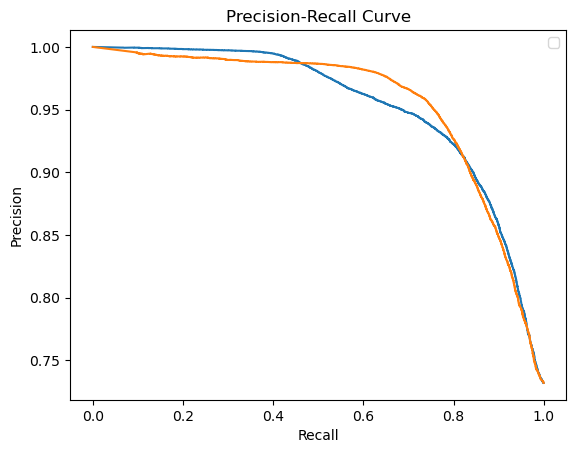

In [17]:
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

def calc_and_print_metrics(y_test,reconsturctions,name, mse_ratio=0.5,pred_treshold=0.5):
    
    if(name.find("auto") != -1):
        if(name.find("sub") != -1):
            tmp_sub = np.concatenate(list(dataset_tmp_sub.as_numpy_iterator()))
            mse_ = tf.keras.losses.mean_squared_error(tmp_sub, reconsturctions)
            mse = [0.01*x for x in mse_]
        else:  
            tmp = np.concatenate(list(dataset_tmp.as_numpy_iterator()))
            mse = tf.keras.losses.mean_squared_error(tmp, reconsturctions)
        avg =  sum(mse) / len(mse)
        print(avg)
        reconsturctions=list(map(lambda x: sigmoid(x.numpy()-mse_ratio*avg.numpy()), list(mse)))
        y_pred = list(map(lambda x: 0 if sigmoid(x.numpy()-mse_ratio*avg.numpy())<pred_treshold else 1, list(mse)))
    elif(name.find("svm") != -1):
        y_pred = list(map(lambda x: 1 if x==-1 else 0, list(reconsturctions)))
    else:
        y_pred = list(map(lambda x: 0 if x[0]<pred_treshold else 1, list(reconsturctions)))
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    
    print(f"Metrics for model {name}")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("MCC:", mcc)

    
def print_prec_recall_curve(y_test,reconsturctions,reconsturctions_sub,name, mse_ratio=0.5):
     
    if(name.find("auto") != -1):
        tmp_sub = np.concatenate(list(dataset_tmp_sub.as_numpy_iterator()))
        mse_ = tf.keras.losses.mean_squared_error(tmp_sub, reconsturctions_sub)
        mse = [0.01*x for x in mse_]
        avg =  sum(mse) / len(mse)
        reconsturctions_sub=list(map(lambda x: sigmoid(x.numpy()-mse_ratio*avg.numpy()), list(mse)))
        tmp = np.concatenate(list(dataset_tmp.as_numpy_iterator()))
        mse = tf.keras.losses.mean_squared_error(tmp, reconsturctions)
        avg =  sum(mse) / len(mse)
        reconsturctions=list(map(lambda x: sigmoid(x.numpy()-mse_ratio*avg.numpy()), list(mse)))
        print(reconsturctions)
    
    precision, recall, _ = precision_recall_curve(y_test, reconsturctions)
    precision_sub, recall_sub, _ = precision_recall_curve(y_test, reconsturctions_sub)
    plt.plot(recall, precision)
    plt.plot(recall_sub, precision_sub)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()
    return [precision, recall,precision_sub, recall_sub]
    
actual = test_auto.map(lambda x,y:y)
actual = np.concatenate(list(actual.as_numpy_iterator()))
#calc_and_print_metrics(actual,reconstructions_cnn,"cnn",pred_treshold=0.1)
#calc_and_print_metrics(actual,reconstructions_sub_cnn,"cnn_sub",pred_treshold=0.1)
#calc_and_print_metrics(actual,reconstructions_trans,"trans",pred_treshold=0.1)
#calc_and_print_metrics(actual,reconstructions_sub_trans,"trans_sub",pred_treshold=0.1)
#calc_and_print_metrics(actual,reconstructions_lstm,"lstm",pred_treshold=0.1)
#calc_and_print_metrics(actual,reconstructions_sub_lstm,"lstm_sub",pred_treshold=0.1)
#calc_and_print_metrics(actual,reconstructions_auto,"auto",0.3)
#calc_and_print_metrics(actual,reconstructions_sub_auto,"auto_sub", 0.3)
#calc_and_print_metrics(actual,reconstructions_svm,"svm",pred_treshold=0.1)
#calc_and_print_metrics(actual,reconstructions_sub_svm,"svm_sub",pred_treshold=0.1)

#curve_cnn = print_prec_recall_curve(actual,reconstructions_cnn,reconstructions_sub_cnn,"cnn")
#curve_trans=print_prec_recall_curve(actual,reconstructions_trans,reconstructions_sub_trans,"trans")
#curve_lstm=print_prec_recall_curve(actual,reconstructions_lstm,reconstructions_sub_lstm,"lstm")
curve_auto=print_prec_recall_curve(actual,reconstructions_auto,reconstructions_sub_auto,"auto")

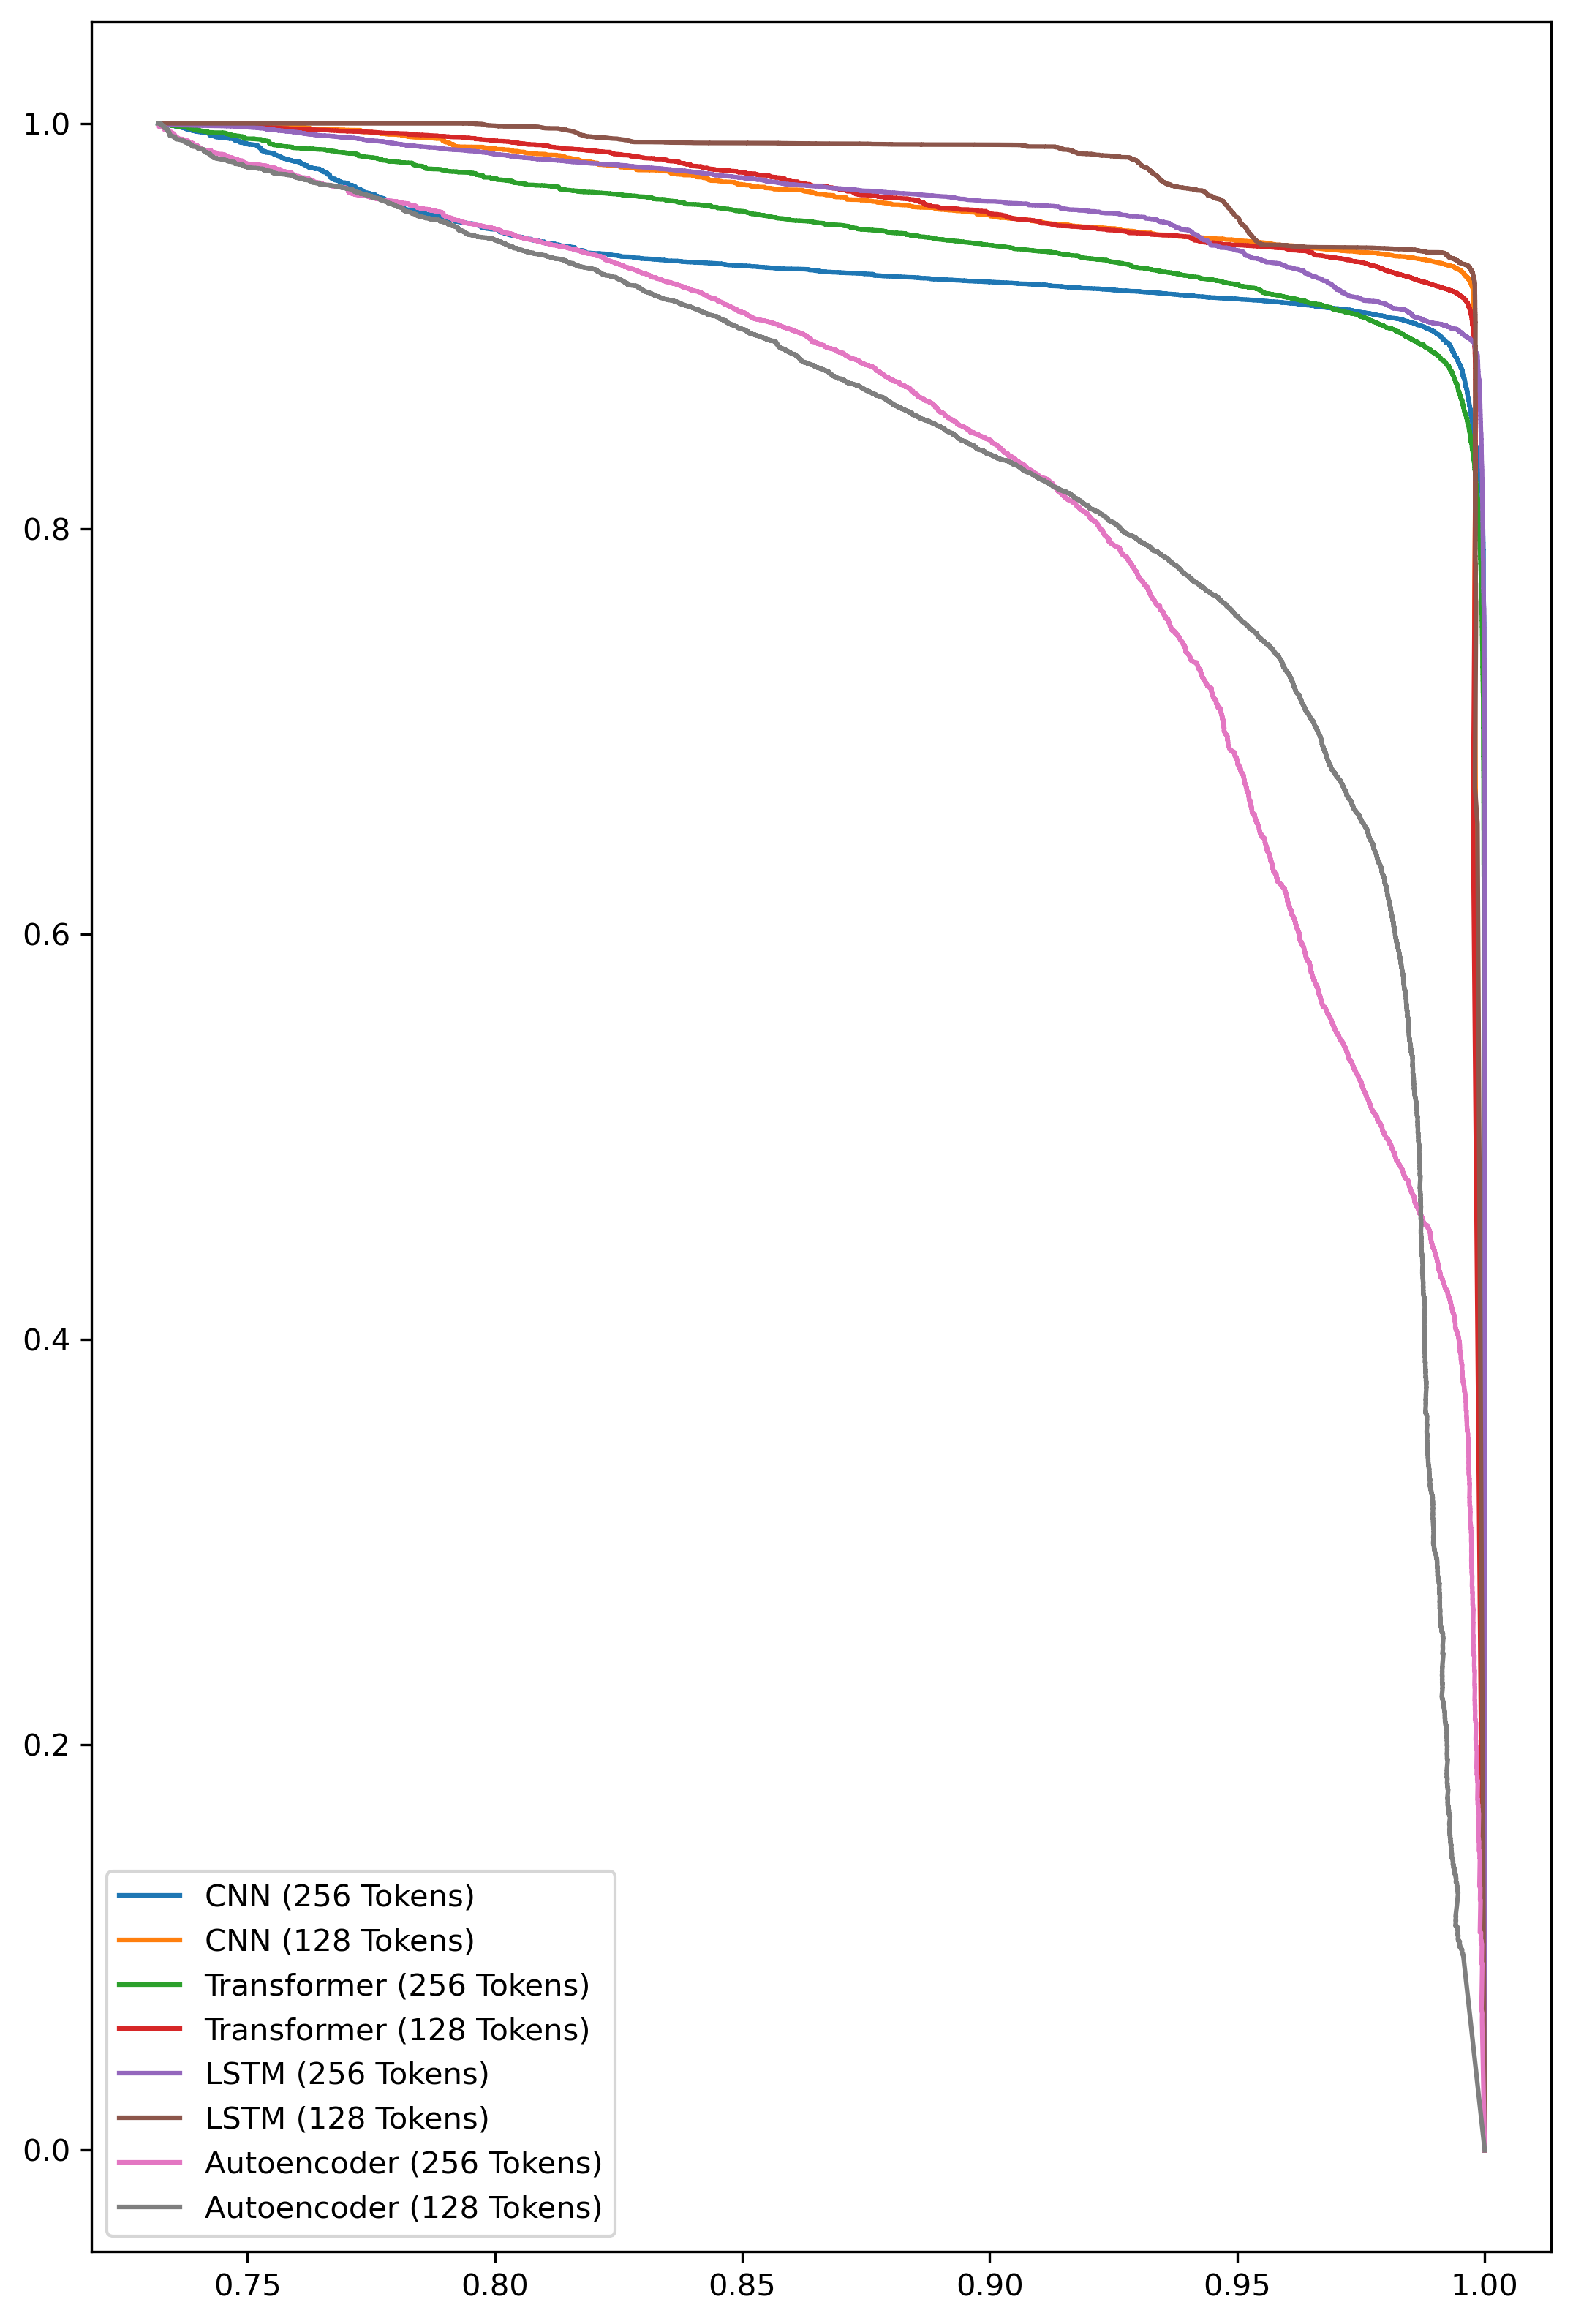

In [20]:
fig = plt.figure(figsize=(7.27, 10.69), dpi=300)
plt.plot(curve_cnn[0], curve_cnn[1], label='CNN (256 Tokens)')
plt.plot(curve_cnn[2], curve_cnn[3], label='CNN (128 Tokens)')
plt.plot(curve_trans[0], curve_trans[1], label='Transformer (256 Tokens)')
plt.plot(curve_trans[2], curve_trans[3], label='Transformer (128 Tokens)')
plt.plot(curve_lstm[0], curve_lstm[1], label='LSTM (256 Tokens)')
plt.plot(curve_lstm[2], curve_lstm[3], label='LSTM (128 Tokens)')
plt.plot(curve_auto[0], curve_auto[1], label='Autoencoder (256 Tokens)')
plt.plot(curve_auto[2], curve_auto[3], label='Autoencoder (128 Tokens)')

# Adding a legend
plt.legend()

plt.tight_layout()
plt.savefig('plot.png', format='png')

# Display the plot
plt.show()

In [84]:
from io import StringIO 
import sys

class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # free up some memory
        sys.stdout = self._stdout

In [13]:

def generate_latex_table_row(model_name, metrics):
    # Create the LaTeX table row template
    table_row = f"{model_name} & "

    # Append the metrics to the table row
    for key, value in metrics.items():
        table_row += f"{key}: {value:.2f} & "

    # Remove the trailing '&' character and add the table row ending
    table_row = table_row.rstrip(" & ") + " \\\\"

    return table_row

def parse_metrics_input(input_string):
    # Split the input string into lines
    lines = input_string.split("\n")

    # Initialize variables
    model_name = None
    metrics = {}

    # Parse the input lines
    for line in lines:
        if line.startswith("Metrics for model"):
            # Extract the model name from the line
            model_name = line.split(" ")[-1]
        elif ":" in line:
            # Split the line into metric name and value
            metric_name, metric_value = line.split(":")
            metric_name = metric_name.strip()
            metric_value = float(metric_value.strip())

            # Add the metric to the dictionary
            metrics[metric_name] = metric_value
    
    return model_name, metrics

input_string = """
Metrics for model cnn
Accuracy: 0.8381496026259765
Precision: 0.9997620782465166
Recall: 0.7790704411406852
F1 Score: 0.8757261572928334
MCC: 0.6966396092483333
Metrics for model cnn_sub
Accuracy: 0.9203470767351716
Precision: 0.9979282125653908
Recall: 0.8930346817460225
F1 Score: 0.9425721746255968
MCC: 0.8274001154686692
Metrics for model trans
Accuracy: 0.9121790685247543
Precision: 0.9851041813048533
Recall: 0.8935329493968643
F1 Score: 0.9370868170328601
MCC: 0.8032607686952989
Metrics for model trans_sub
Accuracy: 0.929286932035047
Precision: 0.9972066326530612
Recall: 0.9059317025689753
F1 Score: 0.9493803848232228
MCC: 0.8436371037142679
Metrics for model lstm
Accuracy: 0.8873272886114386
Precision: 0.9992888305365226
Recall: 0.8466726149781574
F1 Score: 0.9166718940144777
MCC: 0.7711872941351099
Metrics for model lstm_sub
Accuracy: 0.9423913688835359
Precision: 0.9978085828418297
Recall: 0.9233247198692917
F1 Score: 0.9591227521124727
MCC: 0.869560969586339
Metrics for model auto
Accuracy: 0.8067074360257509
Precision: 0.9201174820733998
Recall: 0.8058957809476356
F1 Score: 0.8592272292059179
MCC: 0.5677232758071605
Metrics for model auto_sub
Accuracy: 0.42362530640633084
Precision: 0.9919549477071601
Recall: 0.21431302796092655
F1 Score: 0.35247370025918584
MCC: 0.2543972680056094
Metrics for model svm
Accuracy: 0.8196676816597257
Precision: 0.8221106224493839
Recall: 0.9617376794632615
F1 Score: 0.8864596405970468
MCC: 0.49674785252946285
Metrics for model svm_sub
Accuracy: 0.8185820066327959
Precision: 0.8193321132691815
Recall: 0.9649242749046918
F1 Score: 0.886188162802701
MCC: 0.49301431600324186
"""
metric_sections = input_string.strip().split("Metrics for model")

# Process each metric section and generate the LaTeX table rows
table_rows = []
for metric_section in metric_sections[1:]:
    model_name, metrics = parse_metrics_input("Metrics for model" + metric_section)
    table_row = generate_latex_table_row(model_name, metrics)
    table_rows.append(table_row)

# Print the generated LaTeX table rows
for row in table_rows:
    print(row)

cnn & Accuracy: 0.84 & Precision: 1.00 & Recall: 0.78 & F1 Score: 0.88 & MCC: 0.70 \\
cnn_sub & Accuracy: 0.92 & Precision: 1.00 & Recall: 0.89 & F1 Score: 0.94 & MCC: 0.83 \\
trans & Accuracy: 0.91 & Precision: 0.99 & Recall: 0.89 & F1 Score: 0.94 & MCC: 0.80 \\
trans_sub & Accuracy: 0.93 & Precision: 1.00 & Recall: 0.91 & F1 Score: 0.95 & MCC: 0.84 \\
lstm & Accuracy: 0.89 & Precision: 1.00 & Recall: 0.85 & F1 Score: 0.92 & MCC: 0.77 \\
lstm_sub & Accuracy: 0.94 & Precision: 1.00 & Recall: 0.92 & F1 Score: 0.96 & MCC: 0.87 \\
auto & Accuracy: 0.81 & Precision: 0.92 & Recall: 0.81 & F1 Score: 0.86 & MCC: 0.57 \\
auto_sub & Accuracy: 0.42 & Precision: 0.99 & Recall: 0.21 & F1 Score: 0.35 & MCC: 0.25 \\
svm & Accuracy: 0.82 & Precision: 0.82 & Recall: 0.96 & F1 Score: 0.89 & MCC: 0.50 \\
svm_sub & Accuracy: 0.82 & Precision: 0.82 & Recall: 0.96 & F1 Score: 0.89 & MCC: 0.49 \\


In [88]:
print(a)

None


In [26]:
len(malicious)

25065